In [1]:
import xarray as xr
import matplotlib as mpl
from matplotlib import pyplot as plt
plt.style.use('./grl.mplstyle')
import numpy as np
import pandas as pd
import os
import pickle 

### To-do
Right now there is one case that is not matching between the dissipation and the vorticity P=0.016 v.s. P=0.03


In [2]:
#
from matplotlib.ticker import Locator
class MinorSymLogLocator(Locator):
    """
    Dynamically find minor tick positions based on the positions of
    major ticks for a symlog scaling.
    """
    def __init__(self, linthresh):
        """
        Ticks will be placed between the major ticks.
        The placement is linear for x between -linthresh and linthresh,
        otherwise its logarithmically
        """
        self.linthresh = linthresh

    def __call__(self):
        'Return the locations of the ticks'
        majorlocs = self.axis.get_majorticklocs()

        # iterate through minor locs
        minorlocs = []

        # handle the lowest part
        for i in range(1, len(majorlocs)):
            majorstep = majorlocs[i] - majorlocs[i-1]
            if abs(majorlocs[i-1] + majorstep/2) < self.linthresh:
                ndivs = 10
            else:
                ndivs = 9
            minorstep = majorstep / ndivs
            locs = np.arange(majorlocs[i-1], majorlocs[i], minorstep)[1:]
            minorlocs.extend(locs)

        return self.raise_if_exceeds(np.array(minorlocs))

    def tick_values(self, vmin, vmax):
        raise NotImplementedError('Cannot get tick locations for a '
                                  '%s type.' % type(self))

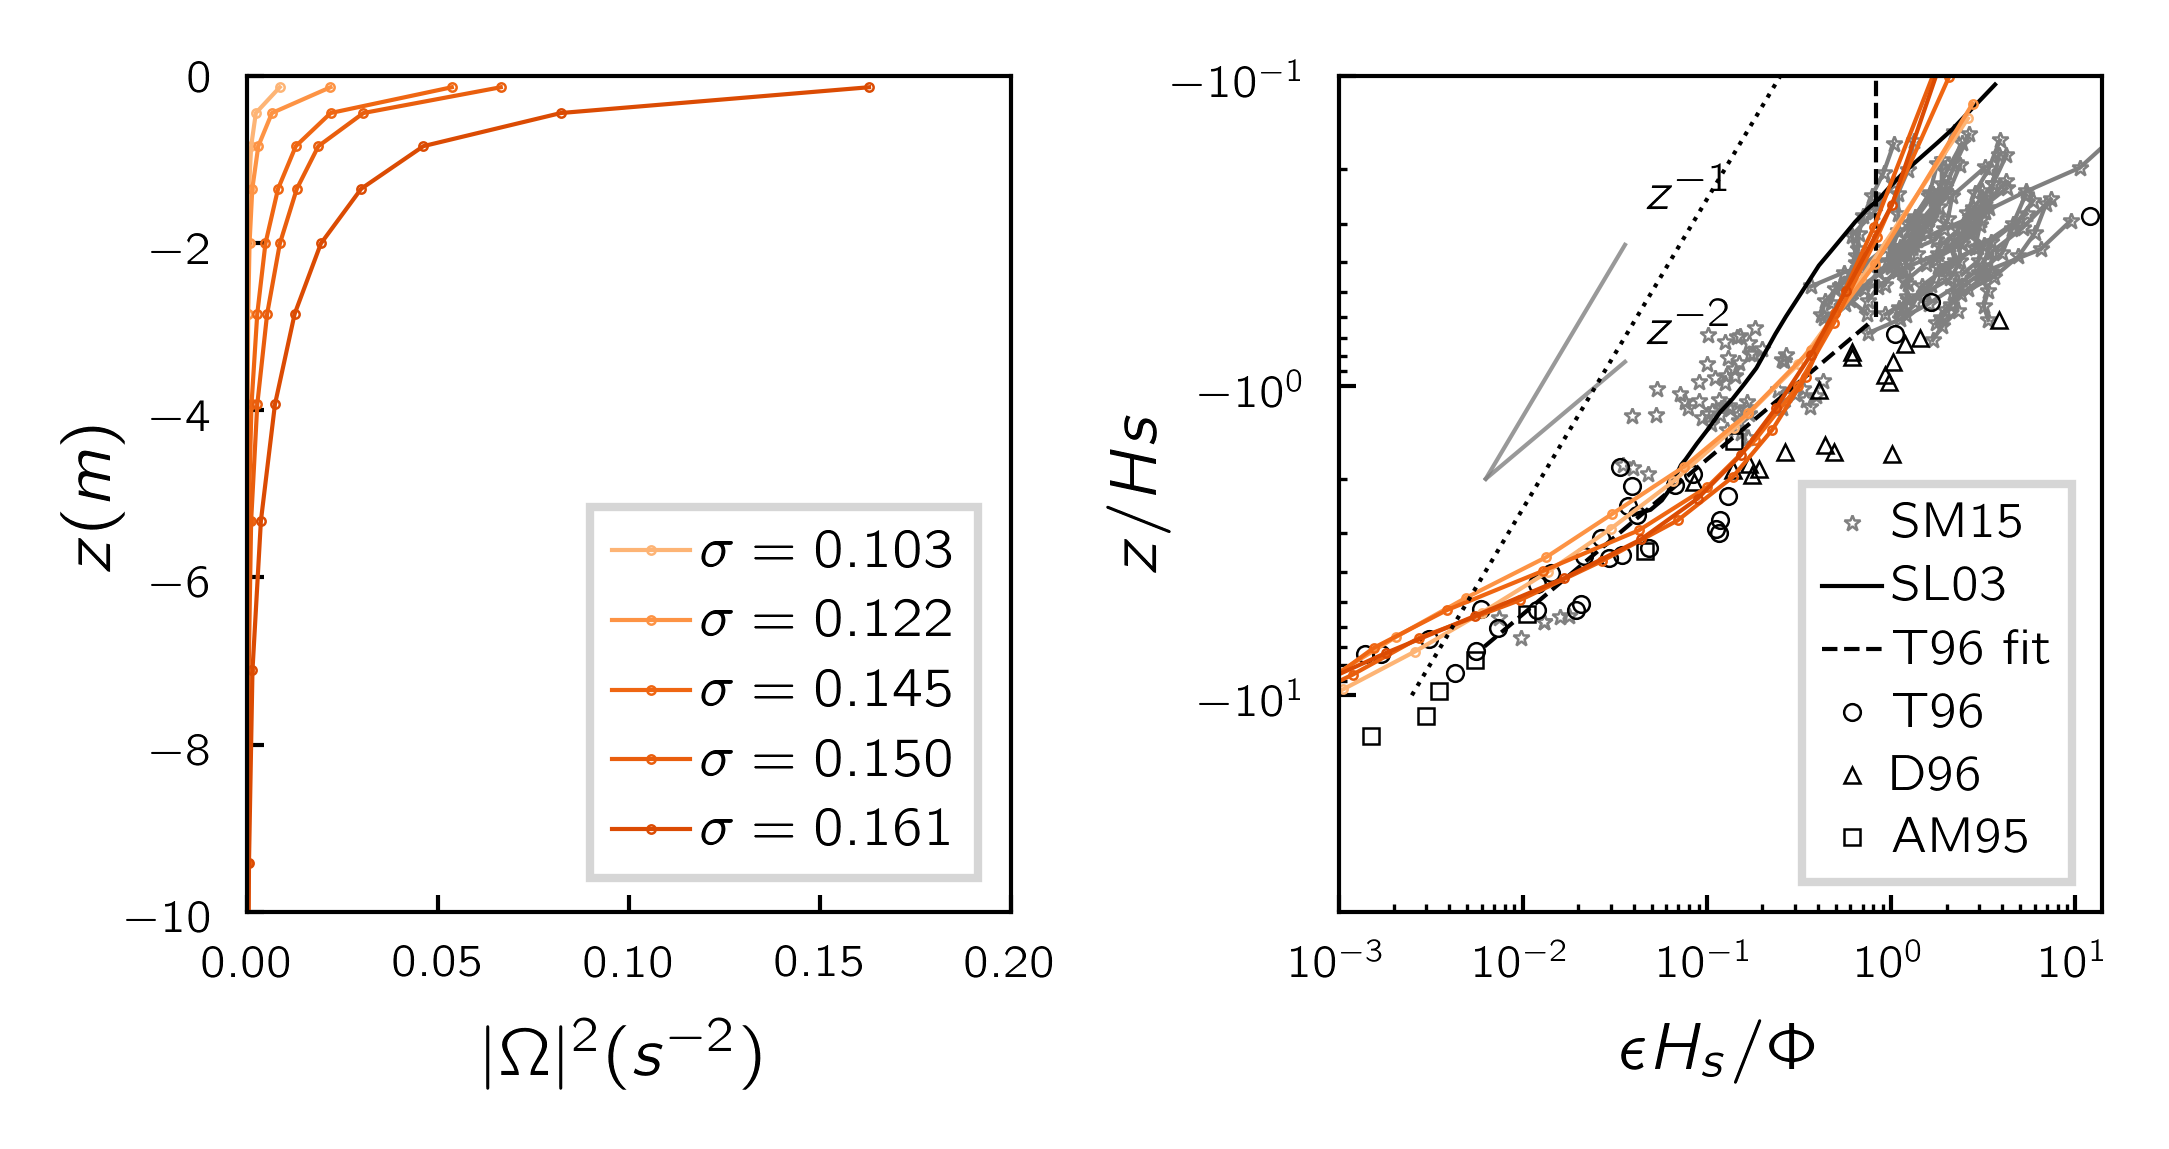

In [10]:
fig, axes = plt.subplots(1, 2, constrained_layout = True, figsize=[3.5,1.8])

# Sutherland 2015
for i in range(1,40):
    file = '../../multilayer/JFM2023/literature_data/SM15/SoCal2010_C1_B2_%d.txt' %i
    if os.path.isfile(file):
        S15 = pd.read_csv('../../multilayer/JFM2023/literature_data/SM15/SoCal2010_C1_B2_%d.txt' %i, delimiter=' ')
        plt.plot(S15.epsilon, S15.z, '*', c='gray')
    file = '../../multilayer/JFM2023/literature_data/SM15/SoCal2010_C1_B3_%d.txt' %i
    if os.path.isfile(file):
        S15 = pd.read_csv('../../multilayer/JFM2023/literature_data/SM15/SoCal2010_C1_B3_%d.txt' %i, delimiter=' ')
        plt.plot(S15.epsilon, S15.z, '*', c='gray')    
    file = '../../multilayer/JFM2023/literature_data/SM15/SoCal2010_C1_VERT_%d.txt' %i
    if os.path.isfile(file):
        S15 = pd.read_csv('../../multilayer/JFM2023/literature_data/SM15/SoCal2010_C1_VERT_%d.txt' %i, delimiter=' ')
        plt.plot(S15.epsilon, S15.z, '-*', c='gray') 
        
for i in range(4,10):
    S15 = pd.read_csv('../../multilayer/JFM2023/literature_data/SM15/SoCal2010_C2_B2_%d.txt' %i, delimiter=' ')
    plt.plot(S15.epsilon, S15.z, '*', c='gray')   
for i in (2,4,5,6,7):    
    S15 = pd.read_csv('../../multilayer/JFM2023/literature_data/SM15/SoCal2010_C3_B2_%d.txt' %i, delimiter=' ')
    plt.plot(S15.epsilon, S15.z, '*', c='gray')   

S15 = pd.read_csv('../../multilayer/JFM2023/literature_data/SM15/SoCal2010_C3_B2_%d.txt' %7, delimiter=' ')
plt.plot(S15.epsilon, S15.z, '*', c='gray', label='SM15')   

# Other data
SL03 = pd.read_csv('../../multilayer/JFM2023/literature_data/SL03.csv', names=['x', 'y'])
axes[1].plot(SL03.x, SL03.y, '-', c='k', label='SL03')

T96fit = pd.read_csv('../../multilayer/JFM2023/literature_data/T96fit.csv', names=['x', 'y'])
# axes[1].plot(T96fit.x, T96fit.y, '--', c='k', label='T96 fit')
# Found the expression for the fit
axes[1].plot(T96fit.y**(-2)*0.3, T96fit.y, '--', c='k', label='T96 fit')
axes[1].vlines(x=0.83, ymin=-0.6, ymax=-0.1, linestyle='--', color='k')

axes[1].plot(12.0484, -0.2830, 'o', c='k')
T96 = pd.read_csv('../../multilayer/JFM2023/literature_data/T96.csv', names=['x', 'y'])
axes[1].plot(T96.x, T96.y, 'o', c='k', label='T96')

xstart = 0.01; ystart = -2.
axes[1].plot(T96fit.x[0:8], -T96fit.x[0:8]**(-0.5)/(-T96fit.x[0]**(-0.5))*(ystart), c='gray', alpha=0.8)
axes[1].annotate('$z^{-2}$',(T96fit.x[8],-T96fit.x[8]**(-0.5)/(-T96fit.x[0]**(-0.5))*(ystart)), fontsize=6)
axes[1].plot(T96fit.x[0:8], -T96fit.x[0:8]**(-1)/(-T96fit.x[0]**(-1))*(ystart), c='gray', alpha=0.8)
axes[1].annotate('$z^{-1}$',(T96fit.x[8],-T96fit.x[8]**(-1)/(-T96fit.x[0]**(-1))*(ystart)), fontsize=6)

D96young = pd.read_csv('../../multilayer/JFM2023/literature_data/D96young.csv', names=['x', 'y'])
axes[1].plot(D96young.x, D96young.y, '^', c='k', label='D96')
D96old = pd.read_csv('../../multilayer/JFM2023/literature_data/D96old.csv', names=['x', 'y'])
axes[1].plot(D96old.x, D96old.y, '^', c='k')

AM95 = pd.read_csv('../../multilayer/JFM2023/literature_data/AM95.csv', names=['x', 'y'])
axes[1].plot(AM95.x, AM95.y, 's', c='k', label='AM95')

# S15 = pd.read_csv('../../multilayer/JFM2023/literature_data/Sutherland_upper.txt', names=['x', 'y'])
# axes[1].plot(S15.x, S15.y, '*', c='k', label='S15')
# S15 = pd.read_csv('../../multilayer/JFM2023/literature_data/Sutherland_lower.txt', names=['x', 'y'])
# axes[1].plot(S15.x, S15.y, '*', c='k')

# After getting data from Peter Sutherland
# for i in range(1,5):
#     S15 = pd.read_csv('../../multilayer/JFM2023/literature_data/HIRES2010_%d.txt' %i, delimiter=' ')
#     plt.plot(S15.epsilon, S15.z, '*', c='k', label='S15')
# for i in (10,11,13,14):
#     S15 = pd.read_csv('../../multilayer/JFM2023/literature_data/RaDyO2019_%d.txt' %i, delimiter=' ')
#     plt.plot(S15.epsilon, S15.z, '*', c='k', label='S15')
    

t = 160 # Plot the last time slice
tbin = 170 # The corresponding center of bins in the dissipation file
for label in ('C1','C2','C3','C4','C5'):
    filename = '../../multilayer/JFM2023/compilation/' + label + '/field'  + '%g.nc' %t 
    ds = xr.open_dataset(filename, engine='h5netcdf')
    omega2 = ds.omegax**2 + ds.omegay**2 + ds.omegaz**2
    omega2mean = omega2.mean(["t","x","y"])
    zmean = ds.z.mean(["x","y"]).to_numpy()
    ds.close()

    # For normalization
    phi = np.trapz(omega2mean, x=zmean)
    filename = '../../multilayer/JFM2023/compilation/' + 'dissipation_' + label + '.nc'
    diss = xr.open_dataset(filename, engine='h5netcdf')
    Hs = diss.Hs.sel(tbin=tbin).values
    sigma = diss.sigma.sel(tbin=tbin).values
    
    cc = mpl.colormaps['Oranges']((sigma-0.05)/(0.2-0.05)) 
    axes[0].plot(omega2mean, zmean, '.-', label=r'$\sigma=%.3f$' %sigma, c=cc)
    # axes[0].plot(epsilon,z,'.-',label=r'$\sigma=%.3f$' %case.mu_plateau, c=case.cc)
    axes[1].plot(omega2mean[3:]*Hs/phi,zmean[3:]/Hs,'.-',c=cc)

# Law of Wall   
y = np.linspace(-10, -0.1, 100) 
axes[1].plot(1/0.4*1/abs(y)/100, y, ':',c='k')   
    
axes[0].legend(loc='lower right')
axes[1].legend(loc='lower right', fontsize=6, handlelength=1.2)
axes[0].set_ylim([-10,0])
axes[0].set_xlim([0,2*10**(-1)])
# axes[0].set_xlabel('$\sum \omega_i^2 (s^{-2})$')
axes[0].set_xlabel(r'$|\mathbf{\Omega}|^2 (s^{-2})$')
axes[0].set_ylabel('$z (m)$', labelpad=0)

# axes[1].set_xlabel('$\sum \omega_i^2 H_s/\Phi$')
axes[1].set_xlabel('$\epsilon H_s/\Phi$')
axes[1].set_ylabel('$z/Hs$', labelpad=0)
axes[1].set_xscale('log'); 
axes[1].set_yscale('symlog', linthresh=1e-2)
axes[1].yaxis.set_minor_locator(MinorSymLogLocator(1e-2))
axes[1].set_ylim([-50,-0.1])
axes[1].set_xlim([0.001,14])
plt.savefig('../figures/multilayer-diss/fig4.pdf', bbox_inches='tight')